In [1]:
import os
from classesCHANGE import PointCloudFiltering, UnsupervisedSegmentationAlgorithm, PointCloudGenerator, CropAnalyzer
import time
import plyfile 
import open3d as o3d
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from scipy.spatial import ConvexHull, distance_matrix

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Instantiate classes
pcd_filtering = PointCloudFiltering()
unsup_segmentation = UnsupervisedSegmentationAlgorithm()
pcd_functions = PointCloudGenerator(r"C:/Users/Jay")


C:\Users\Jay\Documents\Github\HarvestEye
C:\Users\Jay\Documents\Github\HarvestEye\openMVG Built\Windows-AMD64-\Release
C:\Users\Jay\Documents\Github\HarvestEye\openMVG Built\openMVG\exif\sensor_width_database\sensor_width_camera_database.txt


In [3]:
# pcd = o3d.io.read_point_cloud(r'C:\Users\Jay\Documents\Github\HarvestEye\main\avoFixed.ply') #Avocado100_30deg_group1_densified_point_cloud.ply')
pcd = o3d.io.read_point_cloud(r'C:\Users\Jay\Desktop\HazoFixFix.ply') # Avocado100_30deg_group1_densified_point_cloud.ply')# 'C:\Users\Jay\Desktop\avoFixed.ply') 
# pcd = o3d.io.read_point_cloud(r'C:\Users\Jay\Downloads\Avocado_s 100 30deg colorized_fixed.ply')
o3d.visualization.draw_geometries([pcd])


In [4]:
# Downsample the point cloud
voxel_size = 0.2
downsampled_pcd = pcd_functions.downsamples_pointcloud(pcd, voxel_size)

# Normalize the point cloud
xyzrgb_normalized = pcd_functions.pcd_array_normalized(downsampled_pcd)

# Define weights and number of clusters for KMeans
weights = [2, 2, 5, 1, 3, 1]
num_clusters = 2
kmeans_labels, kmeans = unsup_segmentation.normalized_and_weighted_kmeans(weights, xyzrgb_normalized, num_clusters)

# Prepare cluster colors array
cluster_colors = np.zeros_like(xyzrgb_normalized[:, :3])  # Use only the XYZ part for colors

# Define colors for clusters
colors = {
    "green": [0, 150/255, 0],  # Green color
    "brown": [0.647, 0.165, 0.165]  # Brown color
}

# Determine the ground cluster based on the lower average z value
average_z = []
for i in range(num_clusters):
    cluster_points = np.asarray(downsampled_pcd.points)[kmeans_labels == i]
    avg_z = cluster_points[:, 2].mean()
    average_z.append(avg_z)

ground_cluster_label = np.argmin(average_z)
# Assign colors based on cluster sizes
for i in range(num_clusters):
    color = colors["brown"] if i == ground_cluster_label else colors["green"]
    cluster_colors[kmeans_labels == i] = color

seg_pcd = downsampled_pcd
seg_pcd.colors = o3d.utility.Vector3dVector(cluster_colors)
# o3d.visualization.draw_geometries([seg_pcd])

In [5]:
# Now use the classes as needed
pcd_filtering = PointCloudFiltering()

ground_points = np.asarray(seg_pcd.points)[kmeans_labels == ground_cluster_label]
crop_points = np.asarray(seg_pcd.points)[kmeans_labels != ground_cluster_label]


In [6]:
x_min, x_max = np.min(ground_points[:, 0]), np.max(ground_points[:, 0])
x_range = x_max - x_min
grid_resolution = x_range / 2

# Filter the Ground Points list
#filtered_ground_points = pcd_filtering.filter_ground_points(ground_points, 3, grid_resolution, 0.15)
filtered_ground_points = pcd_filtering.filter_ground_points(ground_points, 1, 3, 0.9)
filtered_ground_pcd = o3d.geometry.PointCloud()
filtered_ground_pcd.points = o3d.utility.Vector3dVector(filtered_ground_points)
# o3d.visualization.draw_geometries([filtered_ground_pcd]) #+ [seg_pcd])

In [17]:
filtered_crop_points = crop_points # pcd_filtering.filter_points_by_grid(crop_points, 0.75, 0.75, 10)
filtered_crop_pcd = o3d.geometry.PointCloud()
filtered_crop_pcd.points = o3d.utility.Vector3dVector(filtered_crop_points)
o3d.visualization.draw_geometries([filtered_crop_pcd])

In [8]:
import matplotlib.pyplot as plt
# Function to create a convex hull in the XY plane
def create_convex_hull(cluster_points, plot=False):
    points_xy = cluster_points[:, :2]  # Extract XY coordinates
    hull = ConvexHull(points_xy)
    
    if plot == True:
        # Plotting the convex hull
        plt.figure()
        plt.plot(points_xy[:, 0], points_xy[:, 1], 'o')  # Plot points
        for simplex in hull.simplices:
            plt.plot(points_xy[simplex, 0], points_xy[simplex, 1], 'k-')  # Plot edges of the convex hull

        plt.title('Convex Hull')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)
        plt.show()

    return hull

In [9]:
# Filter points based on DBSCAN clustering
eps = 0.17  # epsilon value for DBSCAN
dbscan_labels, clustered_points_xyz = unsup_segmentation.crop_clustering_dbscan(eps, filtered_crop_points)

import random
#Convert clustered_tree_points to an Open3D point cloud
dbscan_clusters_pcd = o3d.geometry.PointCloud()
dbscan_clusters_pcd.points = o3d.utility.Vector3dVector(clustered_points_xyz)

dbscan_clusters_filtered_points, filtered_labels = pcd_filtering.dbscan_cluster_filtering(dbscan_clusters_pcd, 20, 10000, dbscan_labels)
# Ensure dbscan_clusters_filtered_points is a PointCloud object
if isinstance(dbscan_clusters_filtered_points, o3d.geometry.PointCloud):
    # Assign random colors to each cluster
    cluster_colors = {}
    for label in np.unique(filtered_labels):
        if label == -1:  # Skip noise points
            continue
        color = [random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)]  # Generate a random RGB color
        cluster_colors[label] = color

    # Assign colors to each point based on its cluster
    point_colors = []
    for label in filtered_labels:
        if label == -1:  # Noise points
            point_colors.append([0.5, 0.5, 0.5])  # Gray color
        else:
            point_colors.append(cluster_colors[label])

    # Set colors for the clustered tree points
    dbscan_clusters_filtered_points.colors = o3d.utility.Vector3dVector(point_colors)

    # Set the visualization mode to "unlit" for precise color rendering
#    o3d.visualization.draw_geometries([dbscan_clusters_filtered_points])
else:
    print(f"Expected dbscan_clusters_filtered_points to be a PointCloud, but got {type(dbscan_clusters_filtered_points)} instead.")

[ 0  1  2 ... 31 31 31]


In [10]:

# Convert clustered points to an Open3D point cloud
dbscan_clusters_pcd = o3d.geometry.PointCloud()
dbscan_clusters_pcd.points = o3d.utility.Vector3dVector(clustered_points_xyz)

# Assuming dbscan_clusters_filtered_points and filtered_labels are already defined

cluster_labels = np.unique(filtered_labels)
new_cluster_labels = {}
current_label = 0

for label in cluster_labels:
    if label == -1:  # Skip noise points
        continue
    
    cluster_points = np.asarray(dbscan_clusters_filtered_points.points)[filtered_labels == label]
    hull = create_convex_hull(cluster_points)
    hull_points = cluster_points[hull.vertices]

    # Calculate longest distance within the hull
    dist_matrix = distance_matrix(hull_points, hull_points)
    length = np.max(dist_matrix)

    longest_pair_indices = np.unravel_index(np.argmax(dist_matrix, axis=None), dist_matrix.shape)
    longest_vector = hull_points[longest_pair_indices[0]] - hull_points[longest_pair_indices[1]]
    
    # Calculate the unit vector of the longest distance
    longest_unit_vector = longest_vector / np.linalg.norm(longest_vector)
    perpendicular_vector = np.array([-longest_unit_vector[1], longest_unit_vector[0], 0])  # 90 degrees rotation in 2D
    
    # Project hull points onto the perpendicular vector
    perpendicular_projections = np.dot(hull_points, perpendicular_vector)
    width = np.max(perpendicular_projections) - np.min(perpendicular_projections)

    ratio = np.round(length/width) if width != 0 else 0

    projections = np.dot(cluster_points, longest_vector)
    increments = np.linspace(np.min(projections), np.max(projections), int(ratio) + 1)

    #print(f"Length: {length}\nWidth: {width}\nRatio: {ratio}\n")

    # Split points into new clusters based on increments
    for i in range(len(increments) - 1):
        lower_bound = increments[i]
        upper_bound = increments[i + 1]
        
        # Select points within the current increment range
        new_cluster_points = cluster_points[(projections >= lower_bound) & (projections < upper_bound)]

        # Store new clusters with unique labels
        new_cluster_labels[current_label] = new_cluster_points
        current_label += 1

# Convert new clusters to Open3D point clouds and visualize
final_pcd = o3d.geometry.PointCloud()
for label, points in new_cluster_labels.items():
    # Ensure points are in the correct shape
    if points.shape[1] != 3:
        print(f"Error: Points for label {label} must be 2D array with shape (N, 3), got shape {points.shape}")
        continue  # Skip this cluster if the shape is incorrect

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # Generate a random color
    color = np.random.rand(3)  # Random color in RGB
    pcd.paint_uniform_color(color)  # Assign the same color to all points in the cluster
    
    final_pcd += pcd

# Visualize all clusters in one scene
# o3d.visualization.draw_geometries([final_pcd])

In [11]:
np.unique(new_cluster_labels[0])

array([-47.977365 , -47.97669  , -47.93939  , ...,  -6.0530005,
        -6.0066422,  -5.998436 ])

In [18]:
analyzer = CropAnalyzer()

heights, labels = analyzer.calculate_heights_and_labels(new_cluster_labels, filtered_ground_pcd)

# Calculate cluster centers
cluster_centers = analyzer.calculate_cluster_centers(new_cluster_labels)

# Visualize the heights and point cloud data
analyzer.visualize_the_metrics_and_pcd(heights, final_pcd, cluster_centers, "Height", "m")

TypeError: CropAnalyzer.calculate_heights_and_labels() missing 1 required positional argument: 'filtered_ground_pcd'

In [14]:
analyzer.visualize_height_gradient(dbscan_clusters_filtered_points, filtered_ground_pcd)


KeyboardInterrupt: 

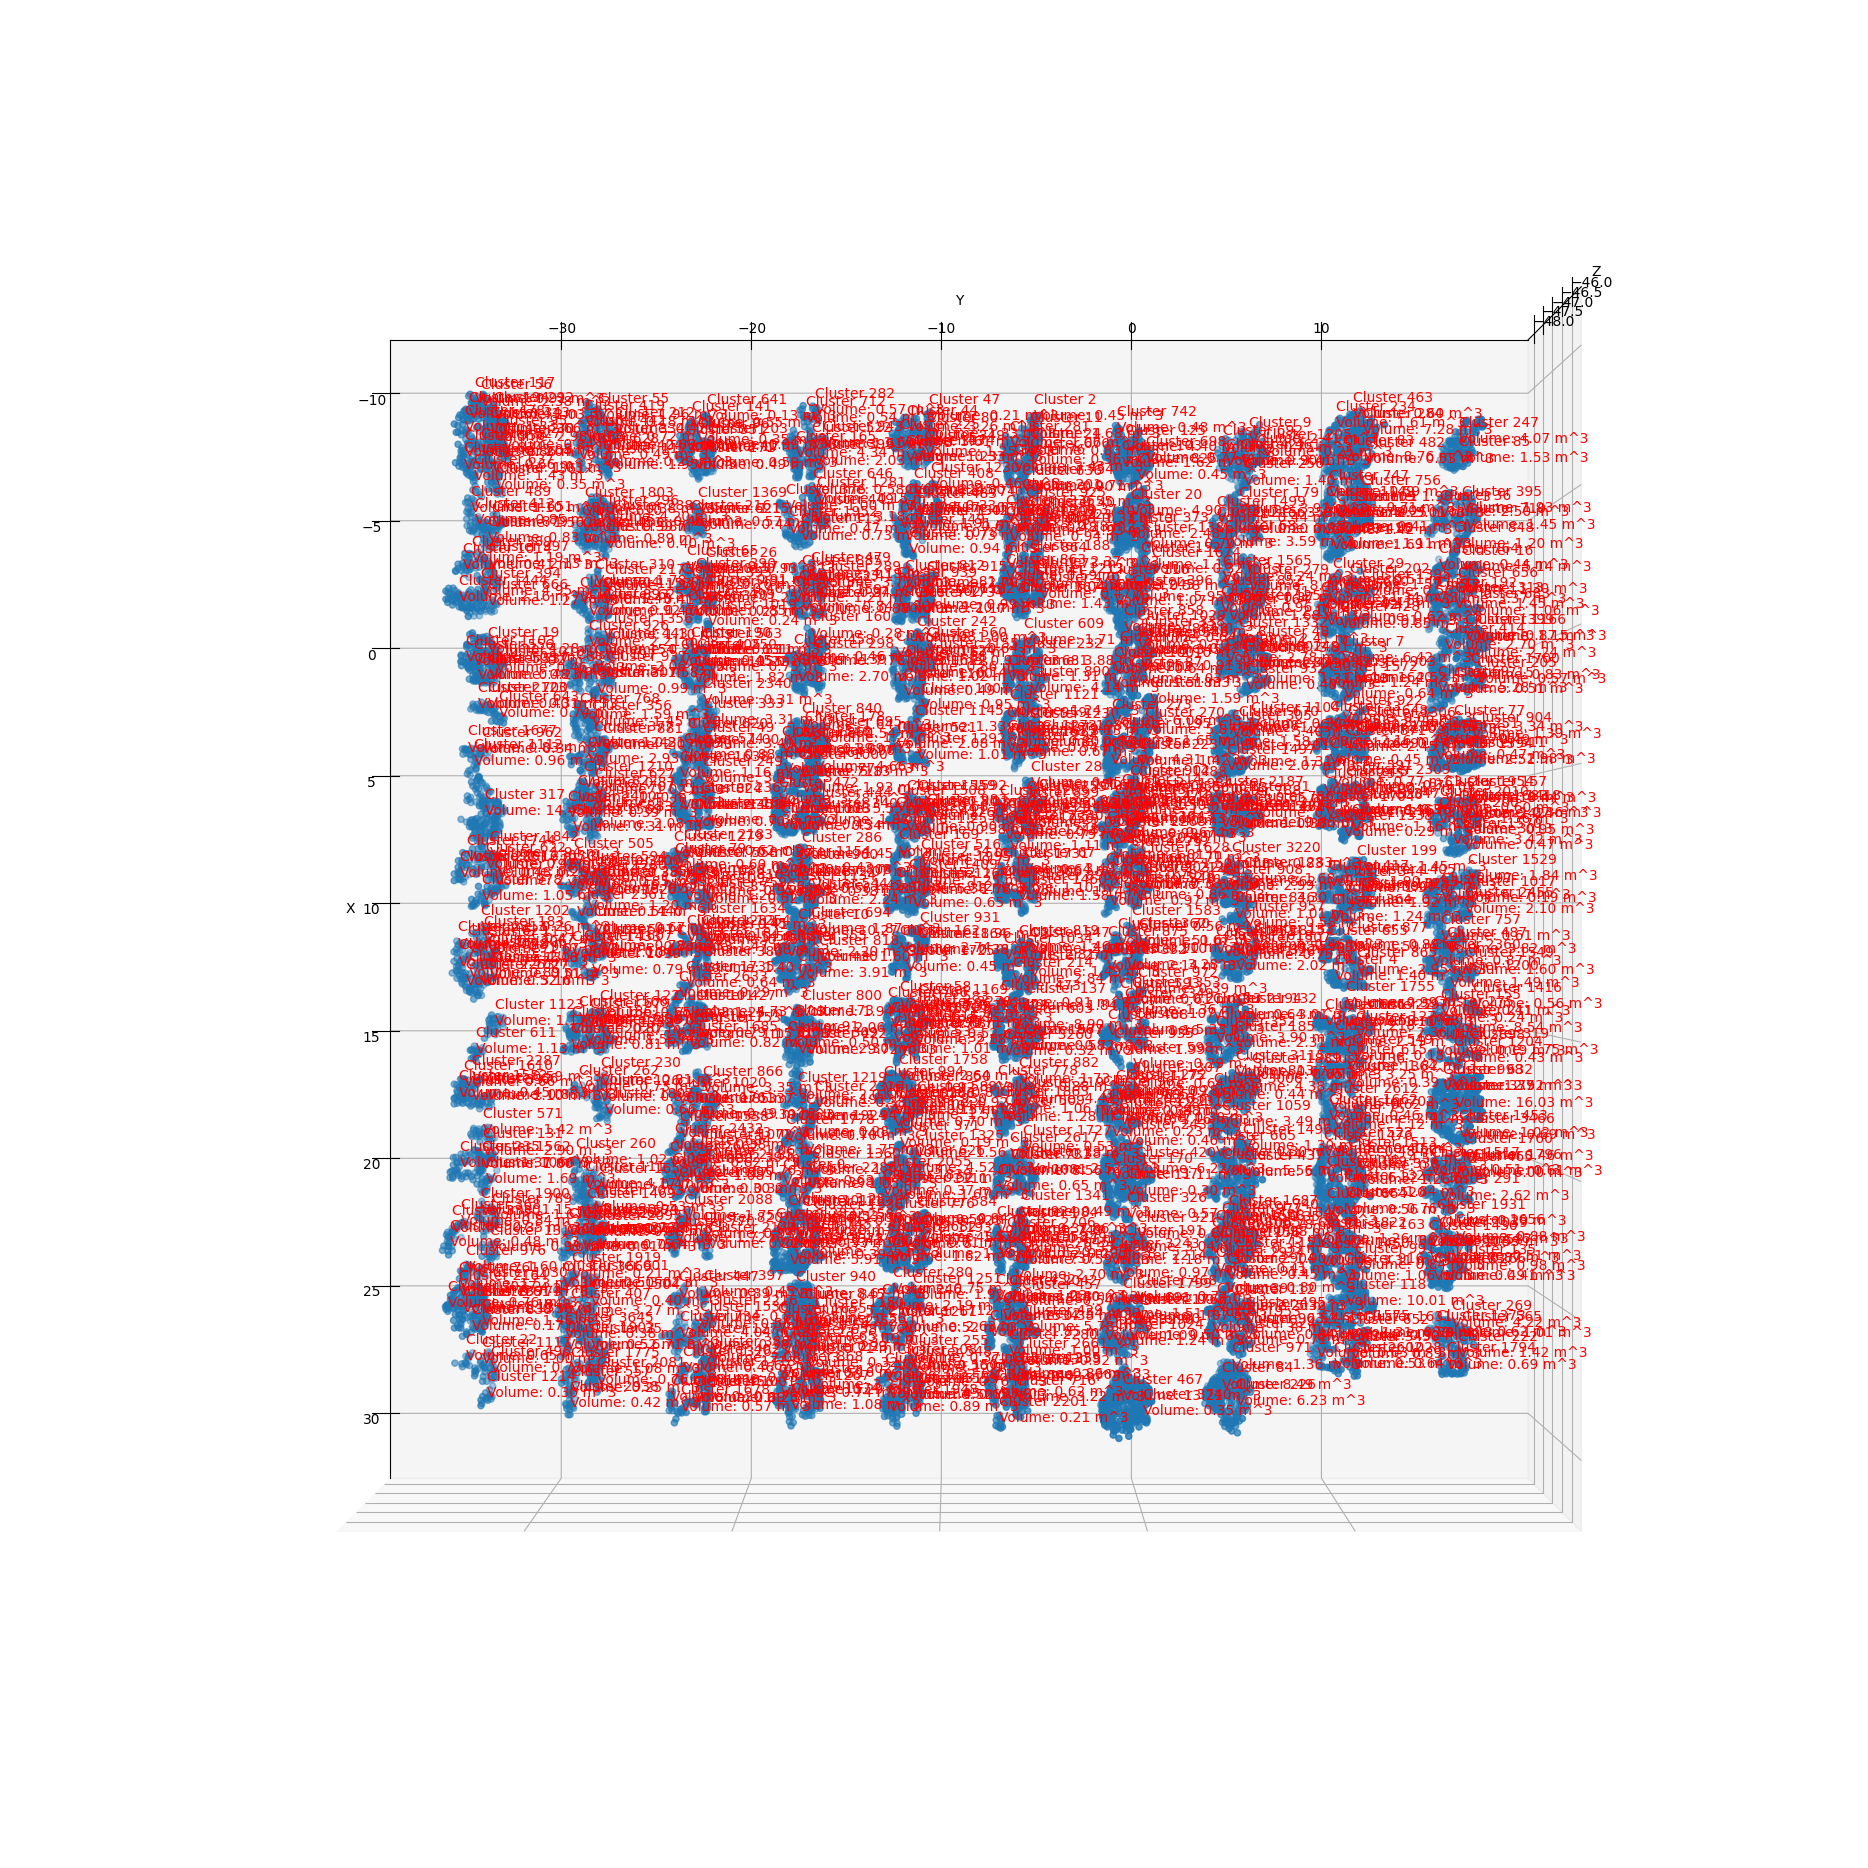

In [ ]:
volume_dicts = analyzer.calculate_volumes_for_clusters(dbscan_clusters_filtered_points, filtered_labels, filtered_ground_pcd)
analyzer.visualize_the_metrics_and_pcd(volume_dicts, dbscan_clusters_filtered_points, cluster_centers, "Volume", "m^3")